In this Python notebook, K-nearest neighbors and random forest algorithms will be applied to predict app ratings on Google play store.

In [1]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Loading the data
df = pd.read_csv('googleplaystore.csv')

In [2]:
%matplotlib inline

In [3]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

# Data Exploration and Cleaning

In [4]:
df.head()
# Executing the above script will display the first five rows of the dataset as shown below

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [5]:
# Checking the data type of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


The dataset has 10,841 records and 13 columns, all of them are object types except the target column (Rating) which is float

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

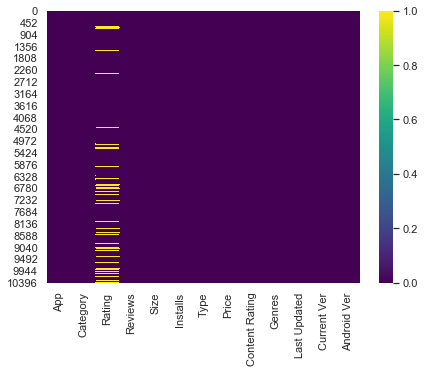

In [6]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

Looks like there are missing values in "Rating", "Type", "Content Rating" and " Android Ver". But most of these missing values in Rating column.

In [7]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

There are two strategies to handle missing data, either removing records with these missing values or replacing missing values with a specific value like (mean, median or mode) value of the column.

In [8]:
# De Rating der ikke har en rating, fill med median
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

In [9]:
# Count the number of unique values in category column 
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [10]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.00,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.00,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.24,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",0.00,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.10,4.4 and up


In [11]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


It's obvious that the first value of this record is missing (App name) and all other values are respectively propagated backward starting from "Category" towards the "Current Ver"; and the last column which is "Android Ver" is left null. It's better to drop the entire recored instead of consider these unreasonable values while cleaning each column!


In [12]:
# Drop this bad column
df = df.drop(i)

In [13]:
# Removing NaN values
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# Categorical Data Encoding¶

Many machine learning algorithms can support categorical values without further manipulation but there are many more algorithms that do not. We need to make all data ready for the model, so we will convert categorical variables (variables that stored as text values) into numircal variables.

In [14]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [15]:
df.head(100)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,6962,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.000,4.0.3 and up
1,2632,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.000,4.0.3 and up
2,8656,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.240,4.0.3 and up
3,7827,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",0.000,4.2 and up
4,7022,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.100,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,663,AUTO_AND_VEHICLES,4.0,1754,14M,"500,000+",Free,0,Everyone,Auto & Vehicles,"June 2, 2018",2.340,4.0 and up
96,5386,AUTO_AND_VEHICLES,4.4,2680,2.2M,"500,000+",Free,0,Everyone,Auto & Vehicles,"March 20, 2018",1.030,4.0.3 and up
97,4812,AUTO_AND_VEHICLES,4.0,1288,4.5M,"100,000+",Free,0,Everyone,Auto & Vehicles,"April 21, 2018",2.170,4.0 and up
98,5289,BEAUTY,4.7,18900,17M,"500,000+",Free,0,Everyone,Beauty,"August 2, 2018",6.101,5.0 and up


In [16]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [17]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [18]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [19]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [20]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [21]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

The above line drops the reference column and just keeps only one of the two columns as retaining this extra column does not add any new information for the modeling process, this line is exactly the same as setting drop_first parameter to True.

In [22]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [23]:
# Convert kbytes to Mbytes 
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter

This can be done by selecting all k values from the "Size" column and replace those values by their corresponding M values, and since k indices belong to a list of non-consecutive numbers, a new dataframe (converter) will be created with these k indices to perform the conversion, then the final values will be assigned back to the "Size" column.

In [24]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

In [25]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,cat_PERSONALIZATION,cat_PHOTOGRAPHY,cat_PRODUCTIVITY,cat_SHOPPING,cat_SOCIAL,cat_SPORTS,cat_TOOLS,cat_TRAVEL_AND_LOCAL,cat_VIDEO_PLAYERS,cat_WEATHER
0,6962,ART_AND_DESIGN,4.1,159,19.0,10000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
1,2632,ART_AND_DESIGN,3.9,967,14.0,500000,1,0,1,12,...,0,0,0,0,0,0,0,0,0,0
2,8656,ART_AND_DESIGN,4.7,87510,8.7,5000000,1,0,1,9,...,0,0,0,0,0,0,0,0,0,0
3,7827,ART_AND_DESIGN,4.5,215644,25.0,50000000,1,0,4,9,...,0,0,0,0,0,0,0,0,0,0
4,7022,ART_AND_DESIGN,4.3,967,2.8,100000,1,0,1,11,...,0,0,0,0,0,0,0,0,0,0


# Evaluation Procedure

In this section shows how k-nearest neighbors and random forests can be used to predict app ratings based on the other matrices. First, the dataset has to separate into dependent and independent variables (or features and labels). Then those variables have to split into a training and test set.

During training stage we give the model both the features and the labels so it can learn to classify points based on the features.

In [26]:
# Split data into training and testing sets
features = ['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

The above script splits the dataset into 85% train data and 25% test data.

# K-Nearest Neighbors Model

The k-nearest neighbors algorithm is based around the simple idea of predicting unknown values by matching them with the most similar known values. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset — its "*nearest neighbors*".

In [28]:
# Look at the 15 closest neighbors
modelKnn = KNeighborsRegressor(n_neighbors=15)

In [29]:
# Find the mean accuracy of knn regression using X_test and y_test
modelKnn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [30]:
# Calculate the mean accuracy of the KNN model
accuracy = modelKnn.score(X_test,y_test)
print(accuracy)

0.9207841338058557


In [31]:
modelKnn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [32]:
#Further analasys
from sklearn.model_selection import GridSearchCV

print("Loading...")

grid = {
    'algorithm': ('auto', 'ball_tree', 'kd_tree'),
    'leaf_size': [10, 30, 50],
    'n_neighbors': [2, 3, 5, 10, 15, 20],
    'weights': ('uniform', 'distance'),
    'p': [1, 2],
    'metric':['minkowski'],
}


grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid=grid, n_jobs=-1, cv=5)
grid_search_knn.fit(X=X_train, y=y_train)
print("-----------")
print(grid_search_knn.best_score_)
print(grid_search_knn.best_params_)

Loading...
-----------
0.9209438612841875
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


In [33]:
#New Model
newKnnModel = grid_search_knn.best_estimator_
newKnnModel.set_params(n_neighbors=20)
newKnnModel.fit(X_train, y_train)
knnpred = newKnnModel.predict(X_test)

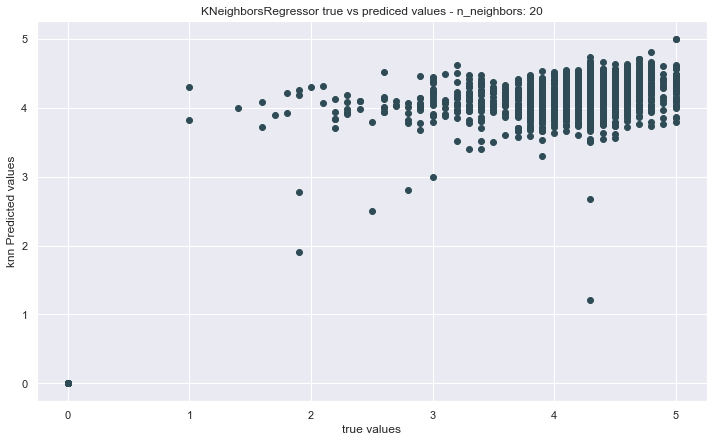

7893     4.3
532      0.0
396      0.0
3309     0.0
3337     0.0
        ... 
9087     4.3
951      4.2
6815     4.3
10576    4.7
1294     4.5
Name: Rating, Length: 2168, dtype: float64


In [34]:
#Plot
plt.figure(figsize=(12,7))
plt.scatter(y_test, knnpred)
plt.title('KNeighborsRegressor true vs prediced values - n_neighbors: 20')
plt.xlabel('true values')
plt.ylabel('knn Predicted values')
plt.show()
np.set_printoptions(threshold=np.inf)
print(y_test)

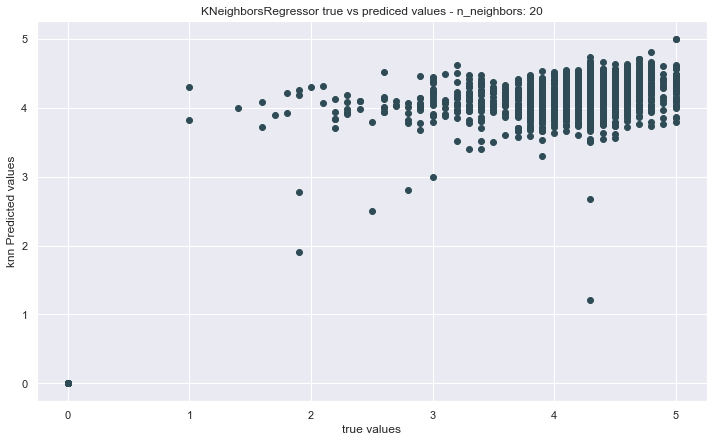

7893     4.3
532      0.0
396      0.0
3309     0.0
3337     0.0
        ... 
9087     4.3
951      4.2
6815     4.3
10576    4.7
1294     4.5
Name: Rating, Length: 2168, dtype: float64


In [35]:
#Plot
plt.figure(figsize=(12,7))
plt.scatter(y_test, knnpred)
plt.title('KNeighborsRegressor true vs prediced values - n_neighbors: 20')
plt.xlabel('true values')
plt.ylabel('knn Predicted values')
plt.show()
np.set_printoptions(threshold=np.inf)
print(y_test)

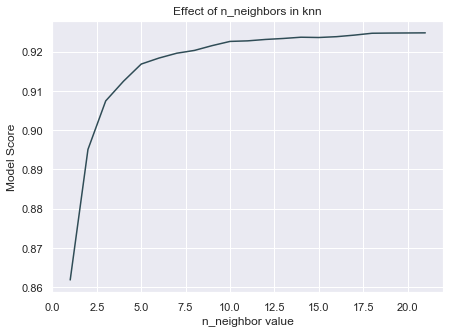

In [36]:
#Select best k-neared nabour fit
n_neighbors = np.arange(1, 22, 1)
scores = []
for n in n_neighbors:
    newKnnModel.set_params(n_neighbors=n)
    newKnnModel.fit(X_train, y_train)
    scores.append(newKnnModel.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of n_neighbors in knn")
plt.xlabel("n_neighbor value")
plt.ylabel("Model Score")
plt.plot(n_neighbors, scores)

In [37]:
#MSE
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error

newKnnpred = newKnnModel.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,newKnnpred))

Mean Absolute Error: 0.26125472501439273


In [38]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
scoreee = lr.score(X_test,y_test)
print(scoreee)

0.918255895160916


In [39]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 46 columns):
App                        10840 non-null int32
Category                   10840 non-null object
Rating                     10840 non-null float64
Reviews                    10840 non-null object
Size                       10840 non-null float64
Installs                   10840 non-null object
Type                       10840 non-null int64
Price                      10840 non-null object
Content Rating             10840 non-null int32
Genres                     10840 non-null int32
Last Updated               10840 non-null float64
Current Ver                10840 non-null float64
Android Ver                10838 non-null object
cat_ART_AND_DESIGN         10840 non-null int64
cat_AUTO_AND_VEHICLES      10840 non-null int64
cat_BEAUTY                 10840 non-null int64
cat_BOOKS_AND_REFERENCE    10840 non-null int64
cat_BUSINESS               10840 non-null int64
cat_COMICS    

In [40]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 20, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

NameError: name 'model' is not defined

# Random Forest Model

The RandomForestRegressor class of the sklearn.ensemble library is used to solve regression problems via random forest. The most important parameter of the RandomForestRegressor class is the n_estimators parameter. This parameter defines the number of trees in the random forest.

In [ ]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [ ]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions)

In [ ]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predictions)

In [ ]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions))